# Optimizing Effect Parameters to Match CLAP Embeddings

## Imports

In [2]:
import os
from pathlib import Path
import requests
from tqdm import tqdm
from typing import Union, List

import math
import torch
import numpy as np
import audiotools
import dasp_pytorch
import auraloss
import laion_clap
from audiotools import AudioSignal

from transformers import BertForMaskedLM


import matplotlib.pyplot as plt
%matplotlib inline

NOTEBOOKS_DIR = Path(os.path.abspath(''))
PROJECT_DIR = NOTEBOOKS_DIR.parent
ASSETS_DIR = PROJECT_DIR / "assets"
PRETRAINED_DIR = PROJECT_DIR / "pretrained"
DATA_DIR = PROJECT_DIR / "data"

In [3]:
# Load audio examples
exts = ["mp3", "wav", "flac"]
example_files = [list(ASSETS_DIR.rglob(f"*.{e}")) for e in exts]
example_files = sum(example_files, [])  # Trick to flatten list of lists


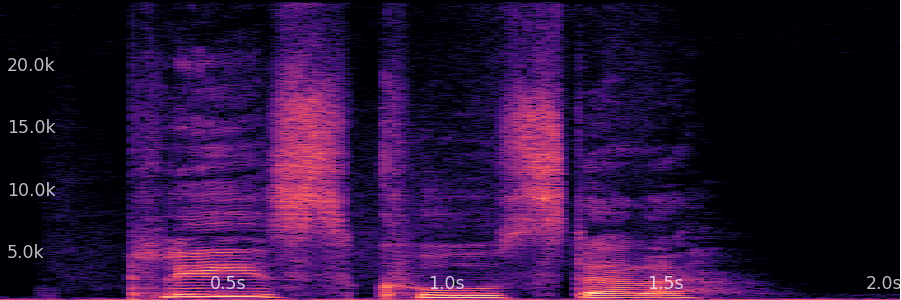
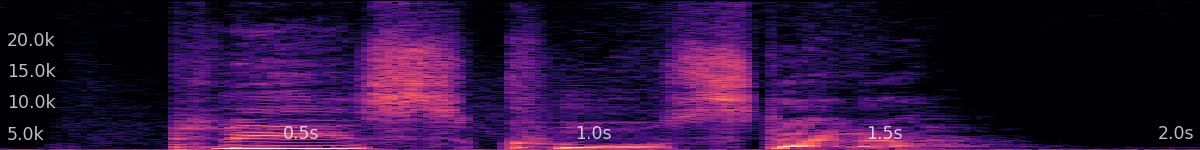

In [4]:
signal = AudioSignal(example_files[5])
signal.widget()

## DASP Effects

The [dasp_pytorch](https://github.com/csteinmetz1/dasp-pytorch) library offers differentiable audio effects implemented in PyTorch.

### Functional Effects

Audio effects are implemented in [__functional__](https://github.com/csteinmetz1/dasp-pytorch/blob/main/dasp_pytorch/functional.py) form. Every function's signature has the format `effect_name(x: torch.Tensor, sample_rate: int, param_1: torch.Tensor, param_2: torch.Tensor, ...)`. The input audio tensor `x` has shape `(n_batch, n_channels, n_samples)`. The function applies the effect using the given parameters (`param_1`, `param_2`, etc.) and returns an output tensor of the same shape as the input.


### Effect Modules

While the functional format is nice, it isn't ideal for neural network-based effects parameter prediction. This is because parameter prediction models typically output a tensor of values corresponding to many different effect parameters. For example, if we have an effects chain of EQ and Compression, we might want our network to predict:

```
[eq_band_1_gain, eq_band_2_gain, ..., eq_band_6_gain, compressor_attack_ms, compressor_release_ms, ..., compressor_threshold_db]
```

simultaneously as a tensor of shape `(n_batch, n_parameters)` and then apply the effects. We don't want to have to reach into this tensor, pick out the different parameters by hand, and pass them to different functions alongside our audio. Instead, it would be much nicer if we could do something like this:

```
params = param_predictor(x)  # Our tensor of parameter values, shape (n_batch, n_parameters)
output_audio = effects(x, params)  # Apply effects
```

The problem here is that our parameters are often scaled differently, with different units and maximum and minimum values -- we might want to cap `eq_band_1_gain` between -10 and 10, but allow `compressor_attack_ms` to range from 0 to 1000. We also have to make sure that the entries in our parameters tensor get mapped to the correct arguments in each effect function.

The `Processor` class handles these issues by wrapping an effect function and providing utilities for parameter scaling and mapping. In the constructor of any `Processor` object, we define:  
* `self.process_fn`: the effect function that we're wrapping
* `self.param_ranges`: a dictionary holding the names of all non-audio, non-sample-rate parameters in the signature of our `process_fn`, and the minimum/maximum values that they take. This is used to break up any input tensor into the values of these specific arguments and scale them appropriately before applying the effect function.
* `self.num_params`: the number of parameters the effect function requires; this is normally just `len(self.param_ranges)`.


The `Processor` class offers the following methods:  
* `.extract_param_dict(param_tensor: torch.Tensor)`: given a parameter tensor, check that it has shape `(n_batch, n_parameters)` and break it up into values for the specific arguments of the wrapped effect function. This is done by creating a dictionary of keyword arguments (e.g. `{"gain_db: torch.Tensor([-24.0])"}`).
* `.denormalize_param_dict(param_dict: dict)`: given an extracted dictionary of parameters, with all values scaled in `(0, 1)`, rescale each parameter so that 0 corresponds to its minimum allowed value and 1 to its maximum allowed value.
* `.process_normalized(x: torch.Tensor, param_tensor: torch.Tensor)`: given an audio input and tensor of predicted parameters, extract and de-normalize the parameters and apply using the wrapped effect function. (AC: this is the one you will use)
* `.process(x: torch.Tensor, *args)`: apply the wrapped effect function to the given input audio with the given arguments. This bypasses all the aforementioned utilities and just calls the wrapped function directly. **(AC: if you wanted to bypass, apply raw values, we will never touch)**
  

Note that `Processor.process_normalized()` expects that any parameter tensor received has already been scaled to `(0, 1)`, e.g. via `torch.sigmoid()`.

### Example: Applying Effects

We need to override the `dasp_pytorch` distortion effect to address some bugs in the repo.

In [5]:
class Distortion(dasp_pytorch.modules.Processor):
    def __init__(
        self,
        sample_rate: int = None,
        min_drive_db: float = 0.0,
        max_drive_db: float = 24.0,
    ):
        super().__init__()
        self.sample_rate = sample_rate
        self.process_fn = dasp_pytorch.functional.distortion
        self.param_ranges = {
            "drive_db": (min_drive_db, max_drive_db),
        }
        self.num_params = len(self.param_ranges)

In [6]:
SAMPLE_RATE = 44_100  # Resample all audio to a fixed rate, and pass to any effects that need it

x = signal.resample(SAMPLE_RATE).audio_data  # (n_batch, n_channels, n_samples)

# Define effects as modules AC: dictionary but applied in fixed order?
fx = {
    "eq": dasp_pytorch.ParametricEQ(sample_rate=SAMPLE_RATE),
    "distortion": Distortion(),
    "reverb": dasp_pytorch.NoiseShapedReverb(sample_rate=SAMPLE_RATE),
    "compressor": dasp_pytorch.Compressor(sample_rate=SAMPLE_RATE),
    "gain": dasp_pytorch.Gain(sample_rate=SAMPLE_RATE),
}

for _n, _fx in fx.items():
    print(f"There are {_fx.num_params} required parameters for effect '{_n}' (min_val, max_val):", _fx.param_ranges, "\n")

There are 18 required parameters for effect 'eq' (min_val, max_val): {'low_shelf_gain_db': (-20.0, 20.0), 'low_shelf_cutoff_freq': (20, 2000), 'low_shelf_q_factor': (0.1, 6.0), 'band0_gain_db': (-20.0, 20.0), 'band0_cutoff_freq': (80, 2000), 'band0_q_factor': (0.1, 6.0), 'band1_gain_db': (-20.0, 20.0), 'band1_cutoff_freq': (2000, 8000), 'band1_q_factor': (0.1, 6.0), 'band2_gain_db': (-20.0, 20.0), 'band2_cutoff_freq': (8000, 12000), 'band2_q_factor': (0.1, 6.0), 'band3_gain_db': (-20.0, 20.0), 'band3_cutoff_freq': (12000, 21050), 'band3_q_factor': (0.1, 6.0), 'high_shelf_gain_db': (-20.0, 20.0), 'high_shelf_cutoff_freq': (4000, 21050), 'high_shelf_q_factor': (0.1, 6.0)} 

There are 1 required parameters for effect 'distortion' (min_val, max_val): {'drive_db': (0.0, 24.0)} 

There are 25 required parameters for effect 'reverb' (min_val, max_val): {'band0_gain': (0.0, 1.0), 'band1_gain': (0.0, 1.0), 'band2_gain': (0.0, 1.0), 'band3_gain': (0.0, 1.0), 'band4_gain': (0.0, 1.0), 'band5_gain

Original signal



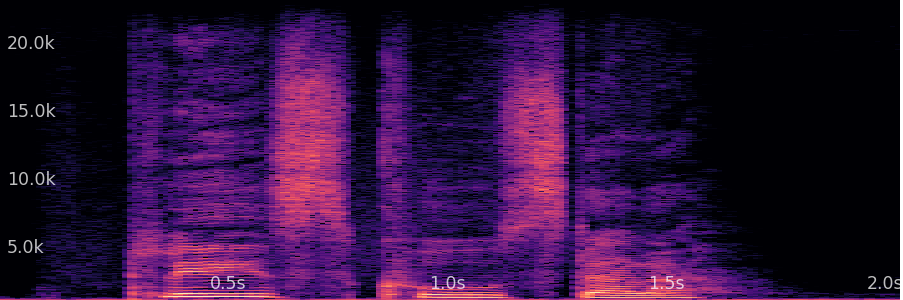
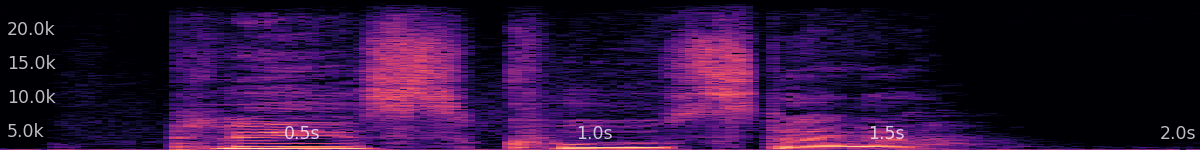

For effect 'eq', selected parameters of shape torch.Size([1, 18])


/home/annie/miniconda3/envs/text2fx/lib/python3.9/site-packages/audiotools/core/audio_signal.py:601: UserWarning: Audio amplitude > 1 clipped when saving
  warnings.warn("Audio amplitude > 1 clipped when saving")



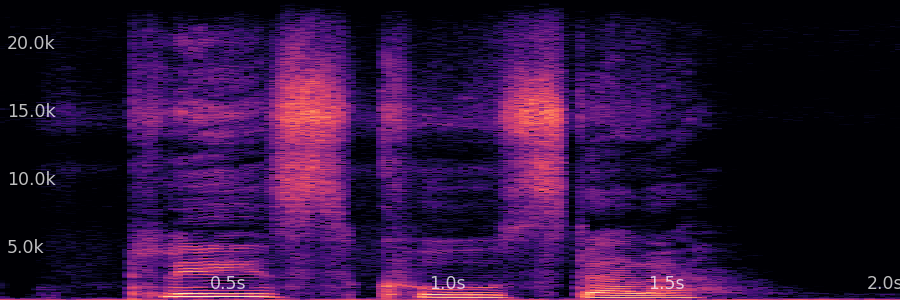
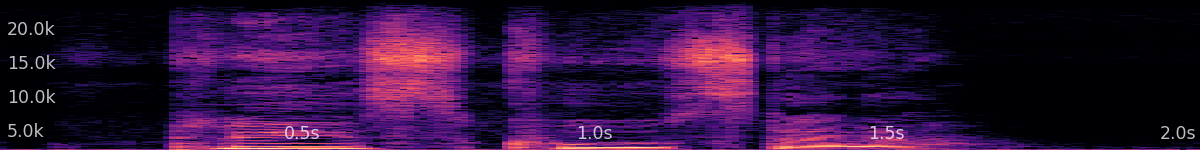

For effect 'distortion', selected parameters of shape torch.Size([1, 1])



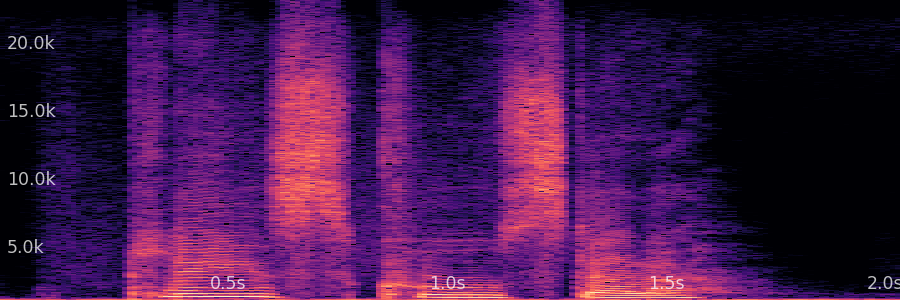
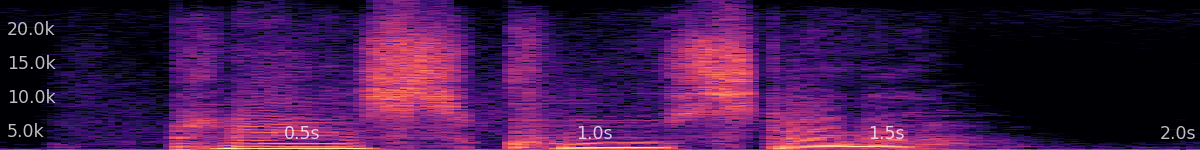

For effect 'reverb', selected parameters of shape torch.Size([1, 25])



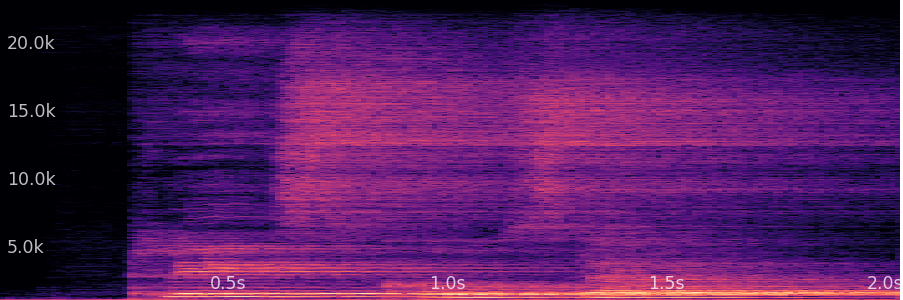
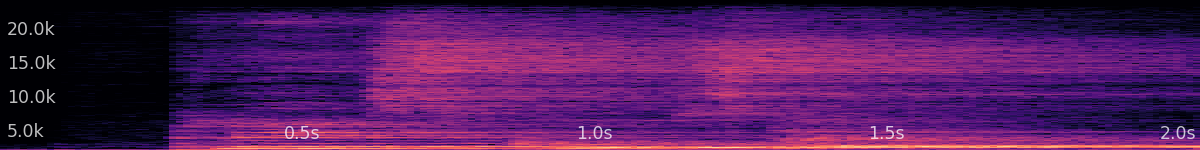

For effect 'compressor', selected parameters of shape torch.Size([1, 6])



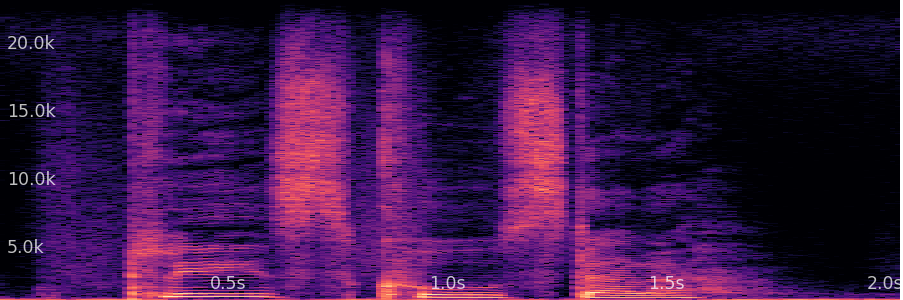
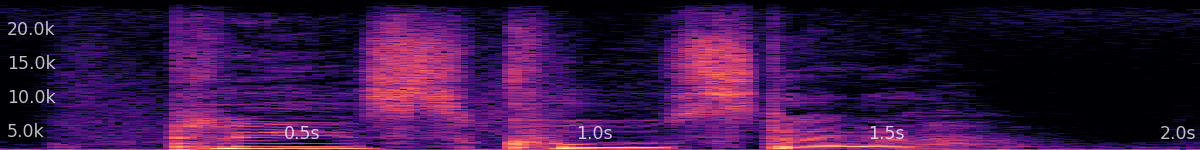

For effect 'gain', selected parameters of shape torch.Size([1, 1])



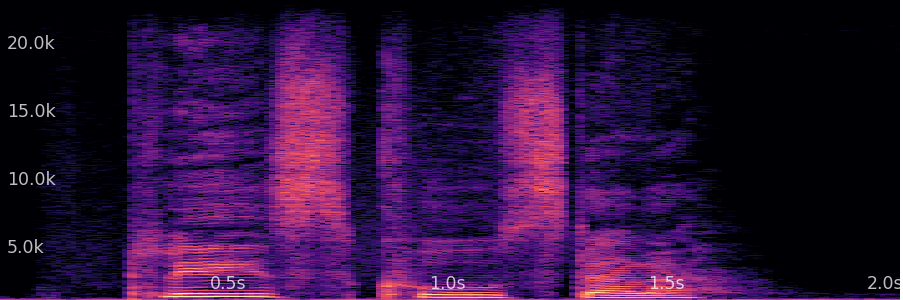
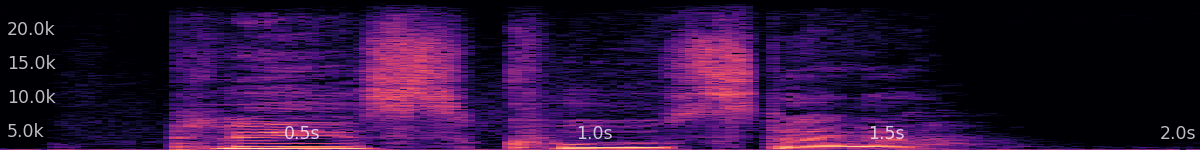

In [7]:
# Original signal
print("Original signal")
signal.widget()

# Create a tensor of "predicted" parameters
params = torch.randn(1, sum([_fx.num_params for _fx in fx.values()]))  # (n_batch, n_parameters)

# Scale parameters to [0, 1]
params = torch.sigmoid(params)

params_count = 0
for _n, _fx in fx.items(): 

    # Select parameters corresponding to current effect module
    selected_params = params[:, params_count: params_count + _fx.num_params]
    params_count += _fx.num_params

    print(f"For effect '{_n}', selected parameters of shape {selected_params.shape}")

    # Process audio AC --> only applying single FX
    out = _fx.process_normalized(x, selected_params)

    out_signal = AudioSignal(out, sample_rate=SAMPLE_RATE)
    out_signal.widget()

## Creating a `Channel`

We can modify the above code slightly to create a wrapper class that applies `dasp_pytorch` effects in sequence.

In [8]:
from typing import Iterable


class Channel(torch.nn.Module):
    def __init__(self, *args):
    
        super().__init__()
    
        modules = []
        if isinstance(args[0], Iterable) and len(args) == 1:
            for m in args[0]:
                assert isinstance(m, dasp_pytorch.modules.Processor)
                modules.append(m)
        else:
            for m in args:
                assert isinstance(m, dasp_pytorch.modules.Processor)
                modules.append(m)

        # Ensure consistent sample rate
        sample_rates = [m.sample_rate for m in modules]

        # If not uniform, go with highest sample rate
        self.sample_rate = max(sample_rates)

        for i, m in enumerate(modules):
            modules[i].sample_rate = self.sample_rate
        self.modules = modules

    @property #AC what does this do? -- hacky thing decorator/annotator, concrete attribute, this is a getter
    def num_params(self):
        return sum([m.num_params for m in self.modules])

    #if you call the object, it automatically calls **forward()** (uses __call__)
    def forward(self, signal: AudioSignal, params: torch.Tensor):

        output = signal.clone().resample(self.sample_rate)
        
        # Check for valid shape
        assert params.ndim == 2  # (n_batch, n_parameters)
        assert params.shape[-1] == self.num_params

        params_count = 0
        for m in self.modules:

            # Select parameters corresponding to current effect module
            _params = params[:, params_count: params_count + m.num_params]
            params_count += m.num_params

            # Apply effect
            output.audio_data = m.process_normalized(output.audio_data, _params) #so assumes _params is normalized [0, 1]

            # Avoid clipping
            output.ensure_max_of_audio()
            
        return output.resample(signal.sample_rate)  # Restore original sample rate

### Quick Examples


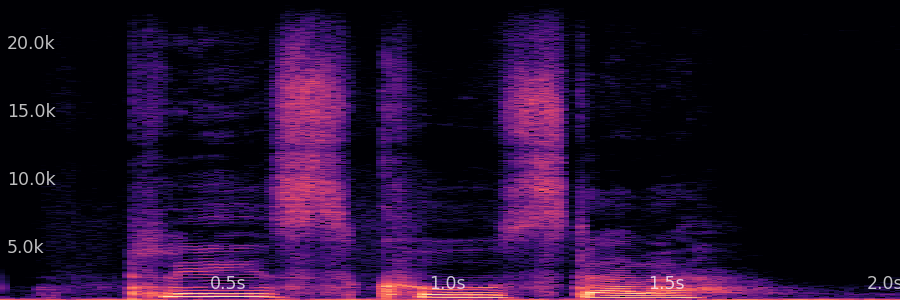
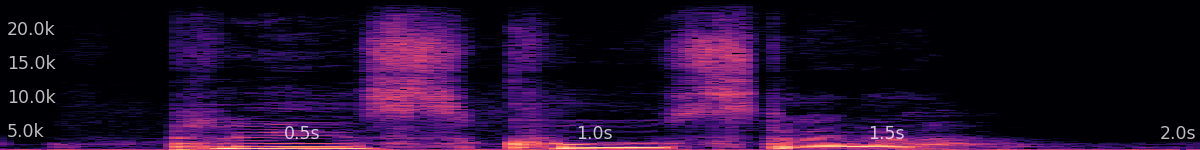

In [9]:
# Apply random EQ, Compression, and Gain to a signal
channel = Channel(
    dasp_pytorch.ParametricEQ(sample_rate=SAMPLE_RATE),
    dasp_pytorch.Compressor(sample_rate=SAMPLE_RATE),
    dasp_pytorch.Gain(sample_rate=SAMPLE_RATE),
)

params = torch.randn(signal.batch_size, channel.num_params)
params_norm = torch.sigmoid(params)

output = channel(signal, params_norm)
output.widget()


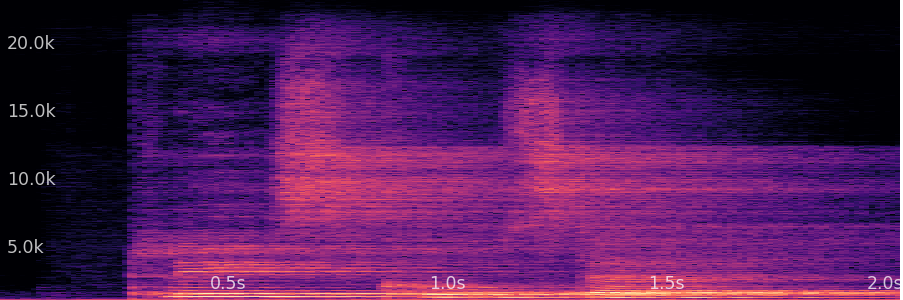
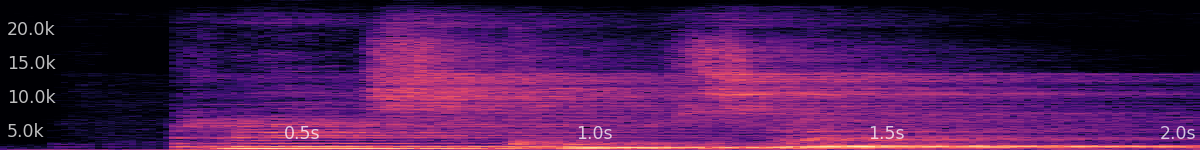

In [10]:
# Apply random Reverb and Distortion to a signal
channel = Channel(
    Distortion(sample_rate=SAMPLE_RATE),
    dasp_pytorch.NoiseShapedReverb(sample_rate=SAMPLE_RATE),
)

params = torch.randn(signal.batch_size, channel.num_params)
params_norm = torch.sigmoid(params)

output = channel(signal, params_norm)
output.widget()

Certain effects, such as reverb, rely on operations (e.g. filtering via convolution) that can be run much faster on GPU. We can try to speed things up with a few changes to our code.


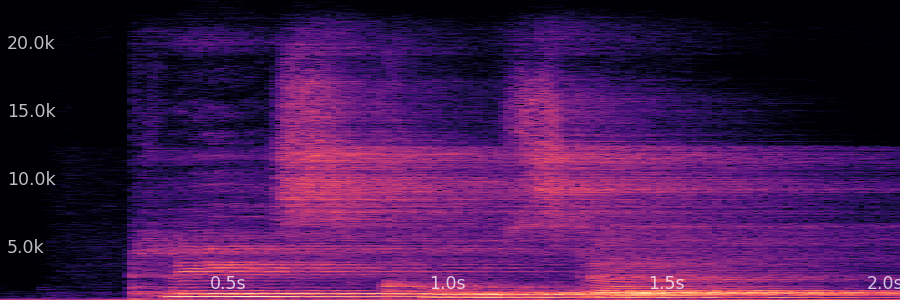
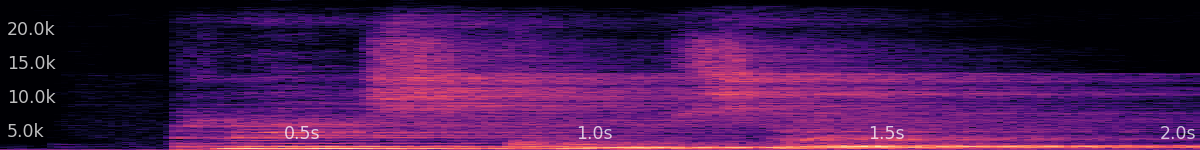

In [11]:
# Let's try to speed up our effects by running on GPU
if torch.cuda.is_available():
    
    params_norm_cuda = params_norm.clone().cuda()
    signal_cuda = signal.clone().cuda()
    output_cuda = channel(signal_cuda, params_norm_cuda)

    output_cuda.cpu().widget()

else:
    print("CUDA not available on this machine; you'll have to use CPU :(")

## Optimizing Effect Parameters

Because our effects modules are differentiable with respect to their parameters, we can optimize the parameters directly in order to steer the output of the effects modules. This is essentially neural network training, except our "network" is a tensor of effect parameters!

### Example 1: Reverse-Engineering Effects Parameters

False
Target audio (we want output to sound like this)



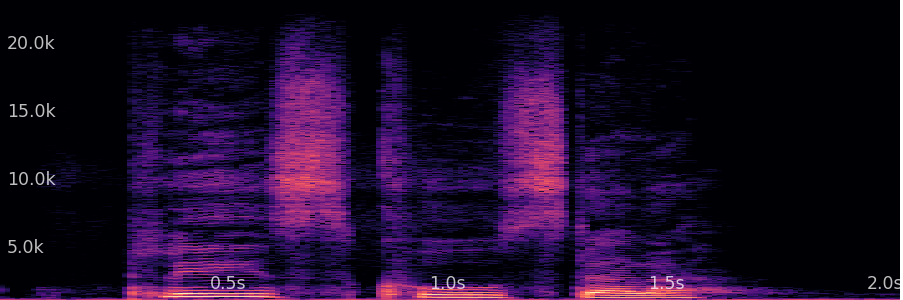
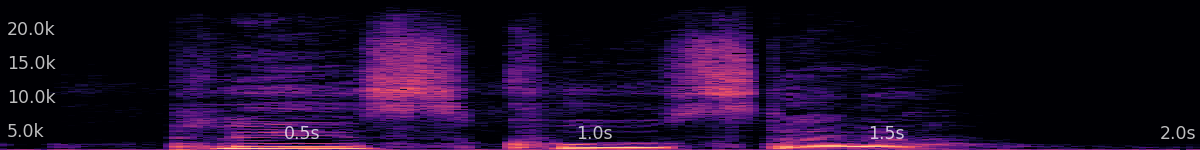

Starting audio



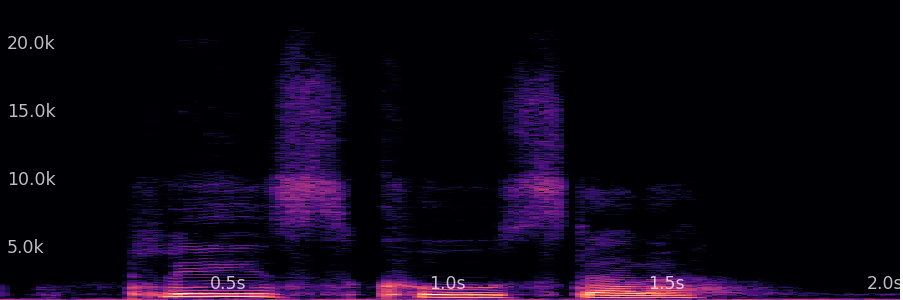
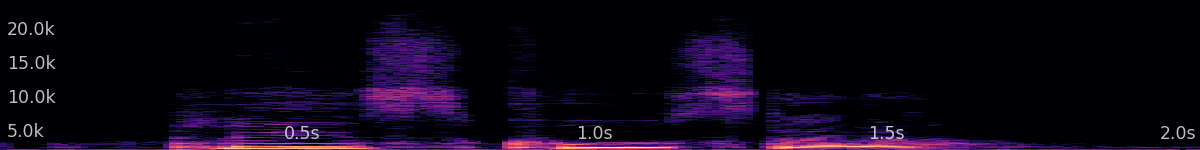

step: 2500/2500, loss: 0.005: 100%|███████| 2500/2500 [01:45<00:00, 23.64it/s]


Final audio



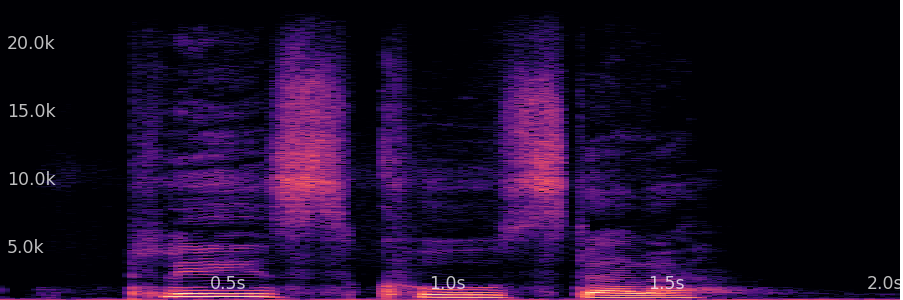
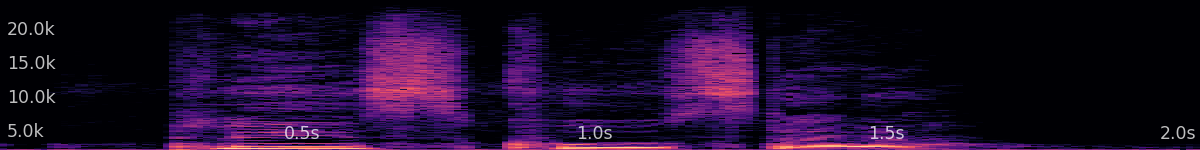

In [12]:
channel = Channel(
    dasp_pytorch.ParametricEQ(sample_rate=SAMPLE_RATE),
    dasp_pytorch.Compressor(sample_rate=SAMPLE_RATE),
)

# Use GPU if available
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
signal = signal.to(device)

# Initialize random parameters as a "target." Our goal will be to optimize a different set of
# random parameters to match these
params_target = torch.randn(signal.batch_size, channel.num_params).to(device) #roughly [-2, 2] 
print(params_target.requires_grad)
# Apply target parameters to get target audio. We will optimize by matching this audio, without any access to
# the target parameters. This mimics the fact that in many real-world scenarios, we won't know the actual 
# target parameters, and will have to estimate them from audio

#AC: so applying torch.sigmoid() to param_target values, then Channel() applies them to the signal in series, right? what does .detach() do?
signal_target = channel(signal.clone().to(device), torch.sigmoid(params_target)).detach() 
#^ autograd -backprop engine, computation graph set of operations tracking gradients, don't track gradients for any of this
# don't often have to use it, but in some cases...

# Initialize our starting parameters
params = torch.nn.parameter.Parameter(torch.randn(signal.batch_size, channel.num_params).to(device))
optimizer = torch.optim.Adam([params], lr=1e-2)

# Play our target and starting audio
print("Target audio (we want output to sound like this)")
signal_target.clone().cpu().widget()
print("Starting audio")
channel(signal.clone().to(device), torch.sigmoid(params)).clone().detach().cpu().widget()

# Optimize our parameters by matching effected audio against the target audio
n_iters = 2500
pbar = tqdm(range(n_iters), total=n_iters)
for n in pbar:
    
    # Apply effect with out estimated parameters
    signal_effected = channel(signal, torch.sigmoid(params))

    # Compute distance between estimate and target spectrograms as our loss; in practice,
    # we can use more complicated loss functions to get better results
    loss = torch.nn.functional.mse_loss( #L2
        signal_effected.magnitude, signal_target.magnitude 
        # .magnitude is a (real) property in audiosignal class and computes spectrogram (phase is imaginary component, don't really need it)
        # there are better resolutions/types of spectrograms -- maybe experiment here (e.g. christian -- auraloss)
    )
    # loss = auraloss(signal_effected=resampled..)

    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pbar.set_description(f"step: {n+1}/{n_iters}, loss: {loss.item():.3f}")

# Play final signal with optimized effects parameters
print("Final audio")
channel(signal.clone().to(device), torch.sigmoid(params)).clone().detach().cpu().widget()
        

Hopefully, our final audio sounds a lot more like our target audio than our starting audio! That doesn't necessarily mean we wound up with the target parameters though -- it's possible we found a new set of parameters that makes the audio sound similar. This is because many different parameter configurations can lead to similar-sounding outputs, and it's one of the reasons we often use audio-matching rather than parameter-matching losses to train parameter predictors.

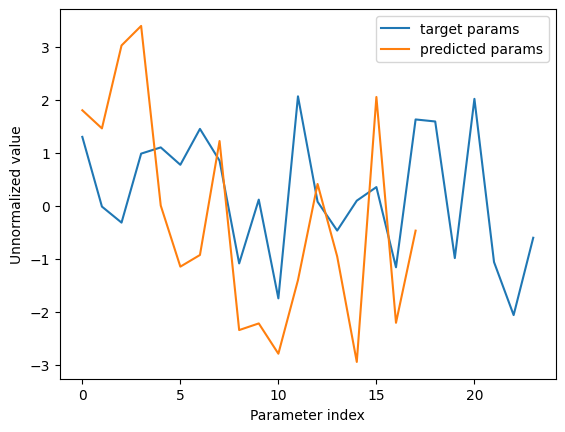

In [19]:
plt.plot(params_target.flatten().cpu().detach(), label="target params")
plt.plot(params.flatten().cpu().detach(), label="predicted params")
plt.ylabel("Unnormalized value") #AC: why is the unnormalized range ~[-2.5, 2.5]?
plt.xlabel("Parameter index")
plt.legend()
plt.show()

# first randn (will give normal distribution [-2.5, 2.5] but ideally parameter UNCONSTRAINED -- then put it into sigmoid [0,1], then put into channel which will scale appropriately


### Example 2: Minimizing CLAP Distance to a Target Description

Above, we optimized effects parameters so that our effects chain would make an audio signal sound like a target; to achieve this, we performed backpropagation using a loss function that measured the difference between our effected audio and the target audio.

What if we want to predict effects parameters that make our audio _sound like_ a given description (e.g. "underwater")? We could try to find a loss function that measures the distance between our effected audio and a given description, so that we could perform backpropagation and minimize this distance. But does such a loss function exist?

#### ... Enter CLAP

CLAP is a pretrained multimodal text-audio embedding model. That means it takes either a text description (e.g. "underwater") or an audio recording as input, and produces as output a _vector_ representation of its input. So if we feed it an underwater audio recording, its output vector will hopefully be similar to what it would produce if we just fed it the description "underwater." Let's try it out!
>Note: If you encounter errors loading pretrained CLAP models below, ensure you have `transformers <= 4.30.0` installed.

In [14]:
import transformers

# Get the version of transformers
transformers.__version__


'4.30.0'

In [15]:

def download_file(url, out_dir, chunk_size: int = 8192):
    
    local_filename = Path(out_dir) / url.split('/')[-1]

    # Determine download size
    response = requests.get(url, stream=True)
    total_bytes = int(response.headers['Content-length'])
    n_iter = total_bytes // chunk_size
    
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in tqdm(r.iter_content(chunk_size=chunk_size), total=n_iter): 
                f.write(chunk)
    return local_filename


# Valid CLAP model names
CLAP_MODELS = [
    '630k-best.pt', # Best non-fusion checkpoint, good for general audio < 10s
    '630k-audioset-best.pt',  # Best non-fusion checkpoint, good for general audio < 10s
    '630k-fusion-best.pt',  # Best fusion checkpoint, good for general audio of variable lengths > 10s
    '630k-audioset-fusion-best.pt',  # Best fusion checkpoint, good for general audio of variable lengths > 10s
    'music_audioset_epoch_15_esc_90.14.pt',  # Specialized for music, best music-tagging performance
    'music_speech_epoch_15_esc_89.25.pt',  # Specialized for music and speech, near-best music-tagging performance
    'music_speech_audioset_epoch_15_esc_89.98.pt',  # For music / speech / general audio, lower music-tagging performance
]

# Valid CLAP audio encoder names
CLAP_AUDIO_MODELS = [
    'HTSAT-base',
    'HTSAT-large',
    'HTSAT-tiny',  # Default
    'HTSAT-tiny-win-1536',
    'PANN-6',
    'PANN-10',
    'PANN-14',
    'PANN-14-fmax-8k-20s',
    'PANN-14-fmax-18k',
    'PANN-14-tiny-transformer',
    'PANN-14-win-1536'
]

CLAP_SAMPLE_RATE = 48_000
CLAP_PRETRAINED_DIR = PRETRAINED_DIR / "clap"
CLAP_DOWNLOAD_LINK = 'https://huggingface.co/lukewys/laion_clap/resolve/main/'
CLAP_MODEL_IDX = 1
CLAP_AUDIO_MODEL_IDX = 2  # Switching this seems to cause issues... it could be all models were trained with HTSAT-tiny
ENABLE_FUSION = CLAP_MODEL_IDX in [2, 3]  # Only some models were trained with segment fusion

ENABLE_FUSION = False

# Ensure that weights are downloaded
ckpt = CLAP_MODELS[CLAP_MODEL_IDX]
ckpt_pth = CLAP_PRETRAINED_DIR / ckpt

if not os.path.exists(ckpt_pth):
    CLAP_PRETRAINED_DIR.mkdir(exist_ok = True, parents= True) #AC added. 
    print(f"Downloading weights for checkpoint {ckpt}")
    ckpt_pth = download_file(CLAP_DOWNLOAD_LINK + ckpt, CLAP_PRETRAINED_DIR)

model = laion_clap.CLAP_Module(enable_fusion=ENABLE_FUSION, amodel=CLAP_AUDIO_MODELS[CLAP_AUDIO_MODEL_IDX])
model.load_ckpt(ckpt_pth)

model = model.to(device)

# Ensure model does not track parameter gradients (wastes memory)
model.eval()
for p in model.parameters():
    p.requires_grad = False

/home/annie/miniconda3/envs/text2fx/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassifica

Load the specified checkpoint /home/annie/research/text2fx/pretrained/clap/630k-audioset-best.pt from users.
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm1.weight 	 Loaded
audio_branch.layers.0.blocks.0.norm1.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.relative_position_bias_table 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.bias 	 Loaded
audio_

In [16]:
def clap_embed_audio(signal: AudioSignal, model: laion_clap.CLAP_Module, quantize: bool = False):
    """
    Given an audio recording, get its CLAP embedding vector.
    """

    # CLAP requires mono 48kHz audio of shape (n_batch, n_samples)
    signal = signal.clone().resample(CLAP_SAMPLE_RATE) 
    x = signal.audio_data.mean(1)
    
    # Quantize audio
    if quantize:
        quant = (x.clone().clamp(min=-1, max=1) * 32767.).to(torch.int16)
        quant = (quant / 32767.).to(torch.float32)

        # Straight-through estimator: no-op on forward pass, preserves gradient on backward pass
        x = x + (quant - x).detach()
    
    emb = model.get_audio_embedding_from_data(x=x, use_tensor=True)

    return emb


def clap_embed_text(text: Union[str, List[str]], model: laion_clap.CLAP_Module):
    """
    Given a text discription, get its CLAP embedding vector.
    """

    if isinstance(text, str):
        text = [text]

    # Account for known batch_size==1 issue
    text_padded = text + ["<null>"]
    
    return model.get_text_embedding(text_padded, use_tensor=True)[:-1]

In [17]:
# Let's try out the model!
audio_emb = clap_embed_audio(signal, model)
text_emb = clap_embed_text(["a woman talking"], model)

print("Audio embedding vector of shape:", audio_emb.shape) 
print("Text embedding vector of shape:", text_emb.shape)

Audio embedding vector of shape: torch.Size([1, 512])
Text embedding vector of shape: torch.Size([1, 512])


#### CLAP Embedding Distance

CLAP is trained so that the distance between two of its embedding vectors should correspond to the distance between _the concepts they represent_. That is, the distance between embedding vectors for a recording of fireworks and the text "fireworks" should be small, while the distance between the same recording and the text "xylophone" should be large.

Because CLAP is a neural network, its mapping from audio to embedding vectors is differentiable. This means that if we want to find effects parameters that move effected audio towards a target description in the CLAP embedding space, we can compute the distance between vectors and backpropagate all the way back to our effects parameters!

To demonstrate, we'll optimize a simple equalizer effect to try to make our audio sound "underwater."

Starting audio



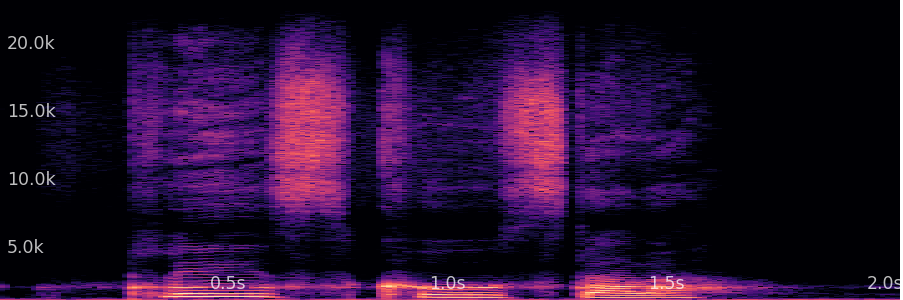
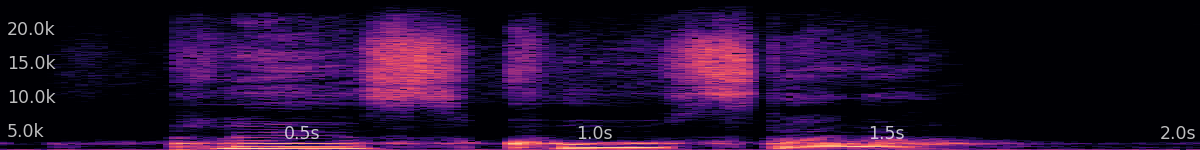

step: 500/500, loss: -0.184: 100%|██████████| 500/500 [00:34<00:00, 14.54it/s]

Final audio



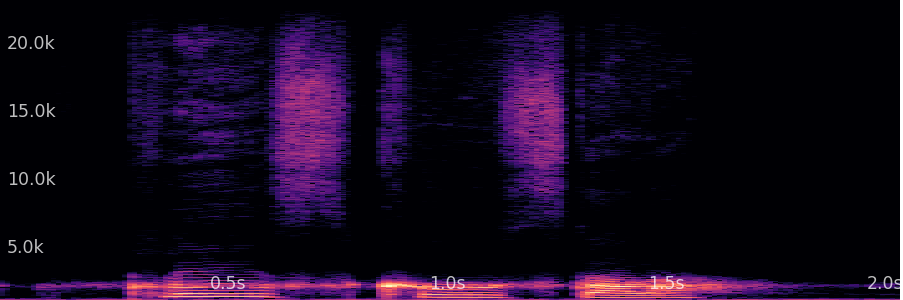
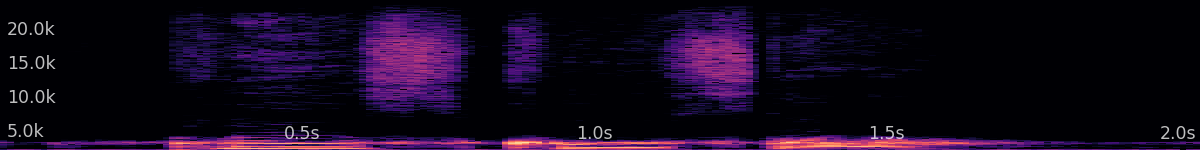

In [18]:
channel = Channel(
    dasp_pytorch.ParametricEQ(sample_rate=SAMPLE_RATE),
)

# Use GPU if available
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
signal = signal.to(device)
model = model.to(device)

# Our target is a CLAP embedding, and we'll perform matching in the embedding space rather than 
# the audio space
text_target = "underwater"
embedding_target = clap_embed_text(text_target, model).detach()

# Initialize our starting parameters
params = torch.nn.parameter.Parameter(torch.randn(signal.batch_size, channel.num_params).to(device))
optimizer = torch.optim.Adam([params], lr=1e-2)

# Play our starting audio
print("Starting audio")
channel(signal.clone().to(device), torch.sigmoid(params)).clone().detach().cpu().widget()

# Optimize our parameters by matching effected audio against the target audio
n_iters = 500
pbar = tqdm(range(n_iters), total=n_iters)
for n in pbar:
    
    # Apply effect with out estimated parameters
    signal_effected = channel(signal, torch.sigmoid(params))

    # Get CLAP embedding for effected audio
    embedding_effected = clap_embed_audio(signal_effected, model, quantize=False)

    # Compute distance between our effected audio embedding vector and the target text 
    # embedding vector. We use cosine distance (essentially the negative dot product
    # between vectors). When two vectors are "aligned" (pointing in the same direction), 
    # their dot product will be high. We thus penalize a small dot product to try to
    # bring our audio vector "into alignment" with the text vector.
    loss = -(embedding_effected @ embedding_target.T).sum()

    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pbar.set_description(f"step: {n+1}/{n_iters}, loss: {loss.item():.3f}")

# Play final signal with optimized effects parameters
print("Final audio")
channel(signal.clone().to(device), torch.sigmoid(params)).clone().detach().cpu().widget()

Did it work? It sounds like our final parameters removed some of the high frequencies, which does make the audio sound a _little_ underwater. Feel free to try other `DASP` effects and descriptions!